In [1]:
import pickle
import random
import torch
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import torch
from VAE import *
from VAE2 import *
from Inference import *
from Train_data import *

num_user     = 100
num_genre    = 10
num_contents = 2000
num_request  = 1000
num_zone     = 2
num_iter = 100
info = [num_user, num_genre, num_contents, num_request, num_zone]

with open("1000_0317_raw.pkl", "rb") as f:
    src = pickle.load(f)
    
g1 = [0 for _ in range(num_contents)]

for i in src[0]:
    for j in i:
        g1[j] += 1
    
with open("inference_0722.pkl","rb") as f:
    p = pickle.load(f)

In [2]:
with open("0512_request.pkl", "rb") as f:
    r1, r2 = pickle.load(f)
    
with open("0722_gw.pkl", "rb") as f:
    w1, w2 = pickle.load(f)


m1 = VAE().to("cuda:0")

m1.load_state_dict(w1)
t1 = inference(m1, info, mode= 'global')
rgt1 = torch.tensor(t1).topk(num_contents)[1].tolist()

In [3]:
def chker1(src, trg, topk):
    s = 0
    t = trg[0:topk]
    for i in t:
        for j in src:
            if i == j:
                s+=1
    return s

def graph_m(model):
    temp = [0 for i in range(num_contents)]
    for i in range(100000):
        t1 = model.sample().tolist()[0]
        for i in range(len(temp)):
            temp[i]+=t1[i]
    for i in range(len(temp)):
        temp[i]/=100000
    plt.stem([i+1 for i in range(len(temp))],temp,'r',label = 'prediction')
    plt.title("Probability Distribution of Movie Popularity")
    plt.xlabel("Movie ID")
    plt.ylabel("Probability")
    plt.legend(loc ='best')
    plt.show()
    return temp

In [4]:
import math as mt
import numpy as np

def CDF(p):    
    dist = [0 for i in range(len(p))]
    for i in range(len(p)):
        for j in range(0, i+1):
            dist[i] += p[j]

    dist = np.array(dist)
    return dist

def binary_search(cdf, target, left, right):
    while left < right:
        mid = (left + right) // 2
        if cdf[mid] < target:
            left = mid + 1
        else:
            right = mid
    return left

def inverse_transform_sampling(cdf, n_samples, left, right, seed):
    np.random.seed(seed)
    u = np.random.rand(n_samples)
    samples = [binary_search(cdf, uu, left, right) for uu in u]
    return samples

class Data_gen():
    def __init__(self, num_user, num_genre, num_contents, num_request, id, ur = 1, lr = 1):
        # self.src = src
        self.ur   = ur
        self.lr   = lr
        self.id   = id
        self.num_user     = num_user
        self.num_contents = num_contents
        self.num_genre    = num_genre
        self.num_request  = num_request
        
        with open("mt_zone1.pkl", "rb") as f:
            self.z1 = pickle.load(f)
    
        with open("mt_zone2.pkl", "rb") as f:
            self.z2 = pickle.load(f)
        # with open("user_genre_prob.pkl", "rb") as f:
        #     self.pg = pickle.load(f)
    def set_ratio(self, zone):
        random.seed(0)
        nu  = int(self.num_user*self.ur)
        u1 = random.sample([i for i in range(10000)], nu)
        
        #u2 = random.sample([i for i in range(10000)], nu)
        rk1 = []
        #rk2 = []
        for u in u1:
            rk1.append(zone[u])
        #for u in u2:
        #    rk2.append(z1[u])
        
        return rk1
    
    def contents_dist(self, q_m, gamma_m):
        n = self.num_contents//self.num_genre
        p_m = [0 for _ in range(n)]
        #q_m = 64
        #gamma_m = 5
        sum = 0
        for i in range(n):
            p_m[i] = (i+q_m)**(-gamma_m)
            sum += p_m[i]
        for i in range(n):
            p_m[i] /= sum

        return p_m

    ## Mzipf of Individual Genre prob
    def genre_dist(self, q_m, gamma_m):
        n = self.num_genre
        p_m = [0 for i in range(n)]
        sum = 0
        for i in range(n):
            p_m[i] = (i+q_m)**(-gamma_m)
            sum+=p_m[i]

        for i in range(n):
            p_m[i] /= sum
            
        return p_m
    
    def user_preference(self, id, rk):
        num_user = len(id)
        p_m = []
        p_c = []
        # for i in id:
        #     p_m.append(self.pg[i])
        for i in id:
            #q_m   = 64 + 2*mt.exp(99 - i)/mt.exp(99)
            q_m   = 64 + 99 - i
            gamma = i*(1.8) + 0.5
            p_m.append(self.genre_dist(q_m, gamma))
            
        for i in range(self.num_genre):
            q_m   = 50 + 0.01*i/2
            gamma = 3 + 0.01*i/2
            p_c.append(self.contents_dist(q_m, gamma))

        p_g = [[0 for _ in range(self.num_genre)] for _ in range(num_user)]
        for u in range(num_user):
            for idx, g in enumerate(rk[u]):
                p_g[u][g-1] = p_m[u][idx]
            
        p_u = [[None for _ in range(self.num_contents)]for _ in range(num_user)]
        for u in range(self.num_user):
            for g in range(self.num_genre):
                for m in range(self.num_contents//self.num_genre):
                    p_u[u][(self.num_contents//self.num_genre)*g+m] = p_g[u][g]*p_c[g][m]

        return p_u
    
    def sampling(self, pu, id, seed):
        z1_req = []
        num_user = len(id)
        for u in range(num_user):
            z1_req.append(inverse_transform_sampling(cdf = CDF(pu[u]), 
                                n_samples = int(self.num_request*self.lr), 
                                left = 0, right = self.num_contents - 1, seed = seed))
        
        return z1_req
    
    def run(self, seed):
        # id  = random.sample(range(0, 10000), 200)

        ## zone1
        rk1  = self.set_ratio(self.z1)
        p1   = self.user_preference(self.id[0], rk1)
        req1 = self.sampling(p1, self.id[0], seed = seed)
        
        ## zone2
        rk2  = self.set_ratio(self.z2)
        p2   = self.user_preference(self.id[1], rk2)
        req2 = self.sampling(p2, self.id[1], seed = seed)
        
        return p1, p2

In [11]:
# k = 200, num_request = 1000
print("Global VS Alogrithm2")
svr1 = [[ [] for _ in range(num_user)] for _ in range(num_zone)]
for topk in [100]:
    for u in range(1, num_user):
        rs = [[] for _ in range(2)]
        pusr1 = p[u]
        pusr1 = torch.tensor(pusr1).topk(num_contents)[1].tolist()

        for s in range(num_iter):
            temp = [0 for _ in range(2)]
            temp[0], temp[1] = chker1(r1[u][s], rgt1, topk), chker1(r1[u][s], pusr1, topk)
            for i in range(2):
                rs[i].append(temp[i])

        print("Topk:",topk, "User:", u)
        za1 = np.array(rs[0]).mean()
        zb1 = np.array(rs[1]).mean()

        print(round(za1,2)," ",round(zb1,2))

        print('-'*50)
        svr1[0][u] = [za1, zb1]


Global VS Alogrithm2
Topk: 100 User: 1
218.13   290.92
--------------------------------------------------
Topk: 100 User: 2
222.28   293.55
--------------------------------------------------
Topk: 100 User: 3
214.5   302.32
--------------------------------------------------
Topk: 100 User: 4
229.69   296.33
--------------------------------------------------
Topk: 100 User: 5
247.99   298.14
--------------------------------------------------
Topk: 100 User: 6
248.47   297.95
--------------------------------------------------
Topk: 100 User: 7
269.65   308.02
--------------------------------------------------
Topk: 100 User: 8
233.67   307.9
--------------------------------------------------
Topk: 100 User: 9
268.77   318.98
--------------------------------------------------
Topk: 100 User: 10
263.9   321.93
--------------------------------------------------
Topk: 100 User: 11
291.14   327.95
--------------------------------------------------
Topk: 100 User: 12
285.14   322.05
----------

Text(0.5, 0, 'user ID')

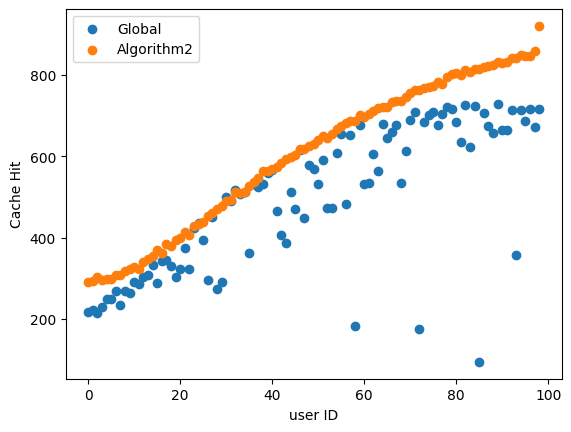

In [17]:
import matplotlib.pyplot as plt
x = [i for i in range(num_user-1)]
lbl = ['Global', 'Algorithm2']
for i in range(len(svr1[0][1])):
    y = []
    for u in range(1, num_user):
        y.append(svr1[0][u][i])
    plt.scatter(x, y, label = lbl[i])
plt.legend()
plt.ylabel("Cache Hit")
plt.xlabel("user ID")


In [58]:
s1 = 0
s2 = 0
for i in svr1:
    s1+=i[0]
    s2+=i[1]
s1 = round(s1/99,2)
s2 = round(s2/99,2)
print(s1, s2, sep='   ')
print(s2/s1*100,'%', sep='')



497.11   603.58
121.41779485425761%


Text(0.5, 0, 'user ID')

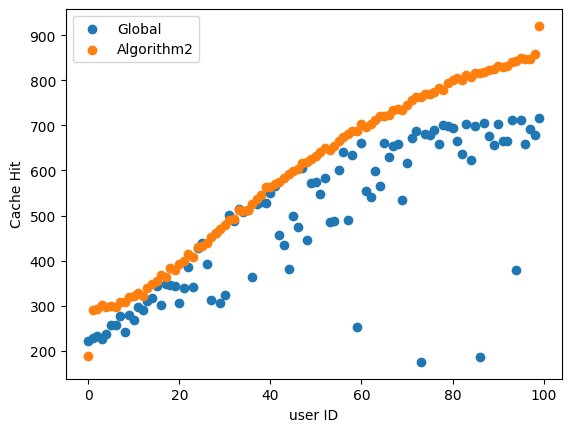

In [20]:
import matplotlib.pyplot as plt
x = [i for i in range(num_user)]
lbl = ['Global', 'Algorithm2']
for i in range(len(svr1[0][0])):
    y = []
    for u in range(num_user):
        y.append(svr1[0][u][i])
    plt.scatter(x, y, label = lbl[i])
plt.legend()
plt.ylabel("Cache Hit")
plt.xlabel("user ID")
